In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from transformers import BartModel, BartConfig
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader
import pickle



In [2]:
DIGITS = 8

In [3]:
class DigitAdditionBinaryDataset(Dataset):
    def __init__(self, size=1000, tokenizer=None, max_length=10, used_data=None):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []
        self.targets = []

        while len(self.data) < size:
            a, b = np.random.randint(0, 2**(DIGITS)), np.random.randint(0, 2**(DIGITS))
            if used_data is None or (a, b) not in used_data:
                a_bin = bin(a)[2:]  # Convert to binary and remove '0b' prefix
                b_bin = bin(b)[2:]
                sum_bin = bin(a + b)[2:]

                self.data.append((a_bin.zfill(DIGITS+1), b_bin.zfill(DIGITS+1)))
                self.targets.append(sum_bin.zfill(DIGITS+1))

                if used_data is not None:
                    used_data.add((a, b))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        a_bin, b_bin = self.data[idx]
        input_text = f"{' '.join(a_bin)} + {' '.join(b_bin)}"
        target_text = ' '.join(self.targets[idx])

        inputs = self.tokenizer(input_text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")
        targets = self.tokenizer(target_text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")

        inputs = {k: v.squeeze() for k, v in inputs.items()}
        targets = {k: v.squeeze() for k, v in targets.items()}

        inputs['labels'] = targets['input_ids']
        
        return inputs

MAX_LENGTH = 24  

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

used_data = set()
train_dataset_add = DigitAdditionBinaryDataset(size=240, tokenizer=tokenizer, max_length=MAX_LENGTH, used_data=used_data)
train_dataloader_add = DataLoader(train_dataset_add, batch_size=1, shuffle=True)

ood_dataset_add = DigitAdditionBinaryDataset(size=16, tokenizer=tokenizer, max_length=MAX_LENGTH, used_data=used_data)
ood_dataloader_add = DataLoader(ood_dataset_add, batch_size=1, shuffle=False)

for batch in train_dataloader_add:
    print("Input IDs:", tokenizer.batch_decode(batch['input_ids']))
    print("Labels:", tokenizer.batch_decode(batch['labels']))
    break

for batch in ood_dataloader_add:
    print("Input IDs:", tokenizer.batch_decode(batch['input_ids']))
    print("Labels:", tokenizer.batch_decode(batch['labels']))
    break


Input IDs: ['<s>0 0 0 0 1 1 0 0 0 + 0 1 0 1 0 0 1 1 0</s><pad><pad><pad>']
Labels: ['<s>0 1 0 1 1 1 1 1 0</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']
Input IDs: ['<s>0 1 0 0 0 1 0 1 0 + 0 0 0 0 0 0 1 0 0</s><pad><pad><pad>']
Labels: ['<s>0 1 0 0 0 1 1 1 0</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']


In [5]:
class DigitMultiplicationBinaryDataset(Dataset):
    def __init__(self, size=1000, tokenizer=None, max_length=10, used_data=None):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []
        self.targets = []

        while len(self.data) < size:
            a, b = np.random.randint(0, 2**(DIGITS)), np.random.randint(0, 2**(DIGITS))
            if used_data is None or (a, b) not in used_data:
                a_bin = bin(a)[2:] 
                b_bin = bin(b)[2:]
                product_bin = bin(a * b)[2:]

                self.data.append((a_bin.zfill(2*DIGITS), b_bin.zfill(2*DIGITS)))
                self.targets.append(product_bin.zfill(2*DIGITS))

                if used_data is not None:
                    used_data.add((a, b))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        a_bin, b_bin = self.data[idx]
        input_text = f"{' '.join(a_bin)} * {' '.join(b_bin)}"
        target_text = ' '.join(self.targets[idx])

        inputs = self.tokenizer(input_text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")
        targets = self.tokenizer(target_text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")

        inputs = {k: v.squeeze() for k, v in inputs.items()}
        targets = {k: v.squeeze() for k, v in targets.items()}

        inputs['labels'] = targets['input_ids']
        
        return inputs

MAX_LENGTH = 36

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

used_data = set()
train_dataset_mult = DigitMultiplicationBinaryDataset(size=49152, tokenizer=tokenizer, max_length=MAX_LENGTH, used_data=used_data)
train_dataloader_mult = DataLoader(train_dataset_mult, batch_size=1, shuffle=True)

ood_dataset_mult = DigitMultiplicationBinaryDataset(size=100, tokenizer=tokenizer, max_length=MAX_LENGTH, used_data=used_data)
ood_dataloader_mult = DataLoader(ood_dataset_mult, batch_size=1, shuffle=False)

for batch in train_dataloader_mult:
    print("Input IDs:", tokenizer.batch_decode(batch['input_ids']))
    print("Labels:", tokenizer.batch_decode(batch['labels']))
    break

for batch in ood_dataloader_mult:
    print("Input IDs:", tokenizer.batch_decode(batch['input_ids']))
    print("Labels:", tokenizer.batch_decode(batch['labels']))
    break


Input IDs: ['<s>0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 * 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0</s><pad>']
Labels: ['<s>0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']
Input IDs: ['<s>0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 * 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0</s><pad>']
Labels: ['<s>0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']


In [7]:
class EncoderOnlyModel(nn.Module):
    def __init__(self, config, num_tokens):
        super(EncoderOnlyModel, self).__init__()
        self.bart_model = BartModel(config).encoder 
        self.linear = nn.Linear(config.d_model, num_tokens) 
        self.loss_fn = nn.CrossEntropyLoss() 

    def forward(self, input_ids, attention_mask=None, labels=None):
        encoder_outputs = self.bart_model(input_ids, attention_mask=attention_mask)
        logits = self.linear(encoder_outputs.last_hidden_state) 

        if labels is not None:
            loss = self.loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
            return loss, logits
        else:
            return logits

config = BartConfig(
    encoder_layers=2,
    encoder_ffn_dim=512, 
    encoder_attention_heads=2, 
    d_model=128, 
    vocab_size=len(tokenizer),
)

num_tokens = len(tokenizer)

model_add = EncoderOnlyModel(config, num_tokens)
model_mult = EncoderOnlyModel(config, num_tokens)



In [9]:
def compute_metrics(eval_pred):
    total = 0
    correct = 0
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    for prediction, label in zip(predictions , labels):
                if torch.equal(torch.from_numpy(prediction), torch.from_numpy(label)):
                    correct += 1

                total += 1

    accuracy = correct / total if total > 0 else 0
    
    return {"accuracy": accuracy}

In [10]:
training_args = TrainingArguments(
    output_dir='../results',         
    report_to="none",
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,
    num_train_epochs=5000,            
    logging_dir='./logs',
    gradient_accumulation_steps=8,
    bf16=True,
    learning_rate = 0.001,
    dataloader_num_workers=16,
    evaluation_strategy="steps",
    logging_steps = 250,
    eval_steps = 250,
    save_strategy="no" 
)

subset_indices = list(range(100))
dataset_mult_subset = Subset(train_dataset_mult, subset_indices)

trainer_add = Trainer(
    model=model_add,
    args=training_args,
    train_dataset=train_dataset_add,
    eval_dataset=ood_dataset_add,
    compute_metrics=compute_metrics
)

trainer_mult = Trainer(
    model=model_mult,
    args=training_args,
    train_dataset=train_dataset_mult,
    eval_dataset=ood_dataset_mult,
    compute_metrics=compute_metrics
)

/local/aabavandpour/anaconda3/envs/sens/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer_add.train()

In [ ]:
trainer_mult.train()

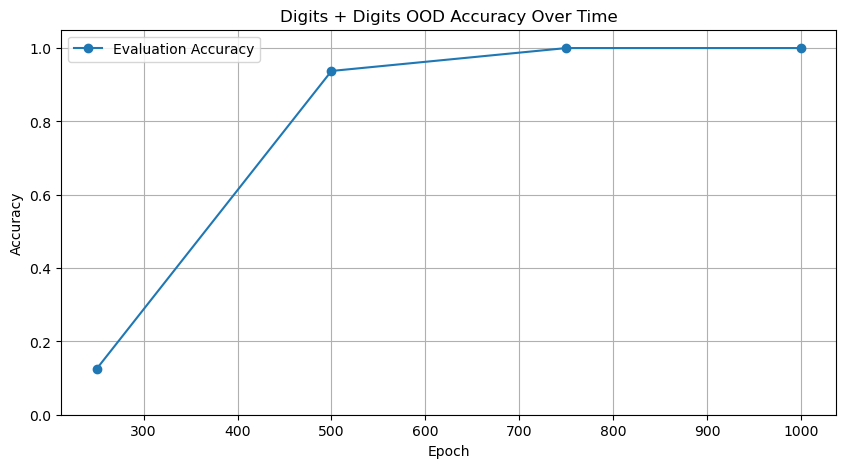

'./results/accuracy_data_4sum_bin_ood_enc.pkl'

In [9]:
#For addition
train_accuracy_history_add = []
eval_accuracy_history_add = []
train_steps_add = []
eval_steps_add = []

for log in trainer_add.state.log_history:
    if 'accuracy' in log:
        train_accuracy_history_add.append(log['accuracy'])
        train_steps_add.append(log['step']) 
    if 'eval_accuracy' in log:
        eval_accuracy_history_add.append(log['eval_accuracy'])
        eval_steps_add.append(log['step']) 


plt.figure(figsize=(10, 5))
plt.plot(eval_steps_add, eval_accuracy_history_add, marker='o', linestyle='-', label="Evaluation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Digits + Digits OOD Accuracy Over Time")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()

data_dict = {
    "train_accuracy_history_add": train_accuracy_history_add,
    "eval_accuracy_history_add": eval_accuracy_history_add,
    "train_steps_add": train_steps_add,
    "eval_steps_add": eval_steps_add
}

file_path = "./results/accuracy_data_4sum_bin_ood_enc.pkl"
with open(file_path, "wb") as f:
    pickle.dump(data_dict, f)

file_path


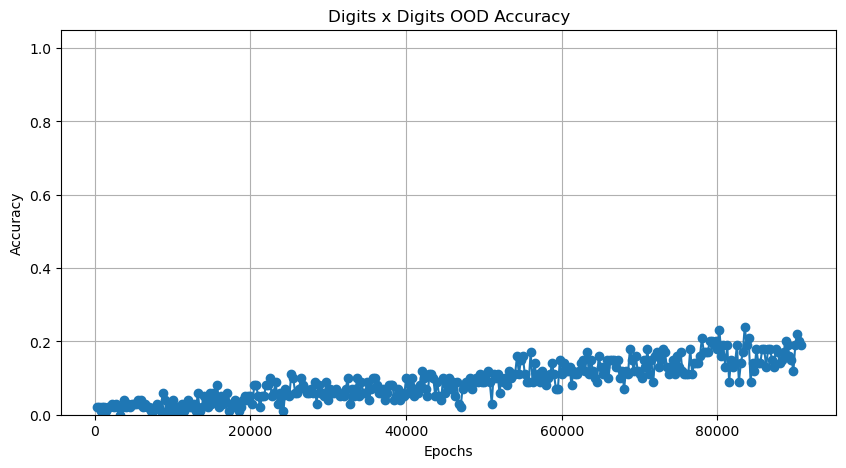

'./results/accuracy_data_8mult_bin_ood_enc.pkl'

In [12]:
#For multiplication
train_accuracy_history_mult = []
eval_accuracy_history_mult = []
train_steps_mult = []
eval_steps_mult = []

for log in trainer_mult.state.log_history:
    if 'accuracy' in log:
        train_accuracy_history_mult.append(log['accuracy'])
        train_steps_mult.append(log['step']) 
    if 'eval_accuracy' in log:
        eval_accuracy_history_mult.append(log['eval_accuracy'])
        eval_steps_mult.append(log['step']) 

plt.figure(figsize=(10, 5))
if eval_accuracy_history_mult:
    plt.plot(eval_steps_mult, eval_accuracy_history_mult, marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Digits x Digits OOD Accuracy")
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()

data_mult_dict = {
    "train_accuracy_history_mult": train_accuracy_history_mult,
    "eval_accuracy_history_mult": eval_accuracy_history_mult,
    "train_steps_mult": train_steps_mult,
    "eval_steps_mult": eval_steps_mult
}
import pickle
file_path_mult = "./results/accuracy_data_8mult_bin_ood_enc.pkl"
with open(file_path_mult, "wb") as f:
    pickle.dump(data_mult_dict, f)

file_path_mult


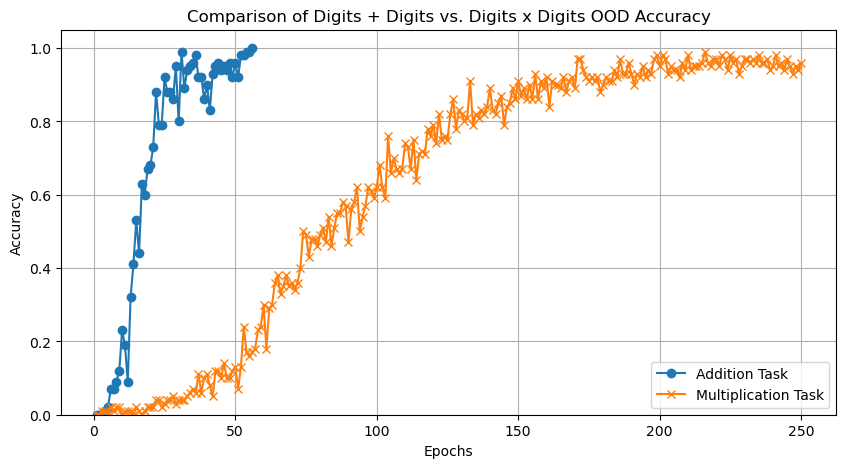

In [13]:
# Load accuracy data for addition
file_path_add = "./results/accuracy_data_2sum.pkl"
with open(file_path_add, "rb") as f:
    data_add = pickle.load(f)

# Load accuracy data for multiplication
file_path_mult = "./results/accuracy_data_2mult.pkl"
with open(file_path_mult, "rb") as f:
    data_mult = pickle.load(f)

eval_accuracy_add = data_add["eval_accuracy_history_add"]
eval_steps_add = data_add["eval_steps_add"]

eval_accuracy_mult = data_mult["eval_accuracy_history_mult"]
eval_steps_mult = data_mult["eval_steps_mult"]

plt.figure(figsize=(10, 5))

plt.plot(eval_steps_add, eval_accuracy_add, marker='o', linestyle='-', label="Addition Task")
plt.plot(eval_steps_mult, eval_accuracy_mult, marker='x', linestyle='-', label="Multiplication Task")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Comparison of Digits + Digits vs. Digits x Digits OOD Accuracy")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)

plt.show()
